# Kaplan-Meier Estimation

Part of [Survival Analysis in Python](https://allendowney.github.io/SurvivalAnalysisPython/)

Allen B. Downey

[Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

[Run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/SurvivalAnalysisPython/blob/master/tutorial/02_kaplan_meier.ipynb)

## Kaplan-Meier estimation

This notebook introduces Kaplan-Meier estimation, a way to estimate a hazard function when the dataset includes both complete and incomplete cases.
To demonstrate, I'll use a small set of hypothetical data.  

Suppose you are investigating the time it takes for dogs to get adopted from a shelter.  You visit a shelter every week for 10 weeks, and record the arrival time for each dog and the adoption time for each dog that was adopted.

Here's what the data might look like.  

In [4]:
obs = pd.DataFrame()

obs['start'] = 0,1,2,2,4,6,7
obs['end'] = 5,2,6,9,9,8,9
obs['status'] = 1,1,1,0,0,1,0

obs

start  end  status
0      0    5       1
1      1    2       1
2      2    6       1
3      2    9       0
4      4    9       0
5      6    8       1
6      7    9       0

This `DataFrame` contains one row for each dog and three columns:

* `start`: arrival time, in weeks since the beginning of the study

* `end`: adoption date, for dogs that were adopted, or `9` for dogs that had not been adopted at the end of the study

* `status`: `1` for dogs that were adopted; `0` for dogs that were not.

## Plotting lifelines

The following function visualizes the data.

In [61]:
def plot_lifelines(obs):
    """Plot a line for each observation.
    
    obs: DataFrame
    """
    for y, row in obs.iterrows():
        start = row['start']
        end = row['end']
        status = row['status']
        
        if status == 0:
            # ongoing
            plt.hlines(y, start, end, color='C0')
        else:
            # complete
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1')
            
    plt.xlabel('Time (weeks)')
    plt.ylabel('Dog index')
    plt.gca().invert_yaxis()

Here are the results:

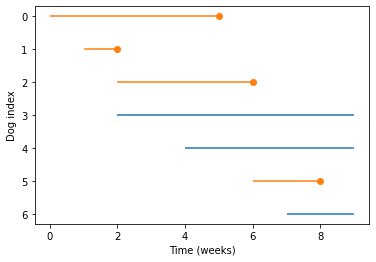

In [62]:
plot_lifelines(obs)

Each line represents the time a dog spends at the shelter. Each dot represents an adoption.
We can see, for example:

* The dog with index 0 arrived during week 0, and was adopted during week 5.

* The dog with index 3 arrived during week 2, and had not been adopted at the end of week 9.


## Estimating survival

Now suppose we want to know the distribution of "survival time" from arrival to adoption.
For the dogs that were adopted, we have all the data we need.  
For the others, we have only partial information: if a dog hasn't been adopted yet, we don't know when it will be, but we can put a lower bound on it.

When we have a mixture of complete and incomplete observations -- adopted and unadopted dogs -- we can't compute the Survival function directly.
Instead, we have to work backwards: we estimate the hazard function first, then use it to compute the survival function, CDF, and PMF.

Specifically, we'll use Kaplan-Meier estimation, which is based on two key ideas.

The first idea is that we can ignore the arrival time in the observed data, and consider only the durations.  In effect, we can take the actual lifelines and shift them so they all start at 0, like this:

In [66]:
duration = obs['end'] - obs['start']

In [67]:
shifted = obs.copy()
shifted['start'] = 0
shifted['end'] = duration

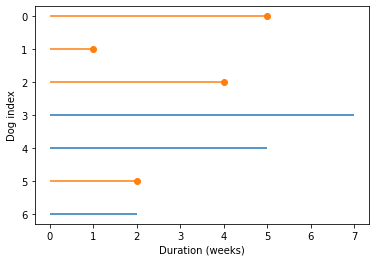

In [68]:
plot_lifelines(shifted)
plt.xlabel('Duration (weeks)');

Notice that the x-axis in this figure is duration, not time.

The second key idea is that we can estimate the hazard function by considering:

* The number of dogs adopted at each duration, divided by

* The number of dogs "at risk" at each duration, where "at risk" means that they *could* be adopted.

For example:

* At duration 1, there is 1 adoption out of 7 dogs at risk, so the hazard rate is `1/7`.

* At duration 2, there is 1 adoption out of 6 dogs at risk, so the hazard rate is `1/6`.

* At duration 4, there is 1 adoption out of 4 dogs at risk, so the hazard rate is `1/4`.

And so on. Now let's see how that works computationally.

## Estimating the hazard function

First I'll select the durations of the complete and ongoing cases.

In [11]:
complete = duration[obs['status']==1]
complete

0    5
1    1
2    4
5    2
dtype: int64

In [12]:
ongoing = duration[obs['status']==0]
ongoing

3    7
4    5
6    2
dtype: int64

Now I'll compute the PMF for complete and ongoing cases: 

In [13]:
def make_pmf(sample):
    return pd.Series(sample).value_counts().sort_index()

In [14]:
pmf_complete = make_pmf(complete)
pmf_complete

1    1
2    1
4    1
5    1
dtype: int64

In [15]:
pmf_ongoing = make_pmf(ongoing)
pmf_ongoing

2    1
5    1
7    1
dtype: int64

Here's what the PMFs look like in a table.

In [74]:
d = dict(pmf_complete=pmf_complete, 
         pmf_ongoing=pmf_ongoing)

In [75]:
index = pmf_complete.index.union(pmf_ongoing.index)

In [76]:
df = pd.DataFrame(d, index=index).fillna(0)
df

pmf_complete  pmf_ongoing
1           1.0          0.0
2           1.0          1.0
4           1.0          0.0
5           1.0          1.0
7           0.0          1.0

This table indicates that one dog was adopted at 1 week, another dog was adopted at 2 weeks, and a third dog was observed, unadopted, having been in the shelter for 2 weeks.

We can use the PMFs to compute survival functions for the two groups:

In [77]:
def make_surv(pmf):
    cdf = pmf.cumsum()
    return pmf.sum() - cdf

In [78]:
df['s_complete'] = make_surv(df['pmf_complete'])
df['s_ongoing'] = make_surv(df['pmf_ongoing'])
df

pmf_complete  pmf_ongoing  s_complete  s_ongoing
1           1.0          0.0         3.0        3.0
2           1.0          1.0         2.0        2.0
4           1.0          0.0         1.0        2.0
5           1.0          1.0         0.0        1.0
7           0.0          1.0         0.0        0.0

The first row of this table indicates that 3 of the adopted dogs and 3 of the unadopted dogs were in the shelter for more than 1 week.

We can use this table to compute the number of dogs "at risk" at each duration, `t`, which is the sum of:

1) The number cases that end at `t`, which is `pmf_complete`.

2) The number of ongoing cases observed at `t`, which is `pmf_ongoing`,

3) The number of complete cases that survive past `t`, which is `s_complete`.

4) The number of ongoing cases that survive past `t`, which is `s_complete`.

Here's what that looks like.

In [79]:
df['at_risk'] = df.sum(axis=1)
df

pmf_complete  pmf_ongoing  s_complete  s_ongoing  at_risk
1           1.0          0.0         3.0        3.0      7.0
2           1.0          1.0         2.0        2.0      6.0
4           1.0          0.0         1.0        2.0      4.0
5           1.0          1.0         0.0        1.0      3.0
7           0.0          1.0         0.0        0.0      1.0



Finally, the hazard function is the ratio of `pmf_complete` and `at_risk`:

In [80]:
df['hazard'] = df['pmf_complete'] / df['at_risk']
df

pmf_complete  pmf_ongoing  s_complete  s_ongoing  at_risk    hazard
1           1.0          0.0         3.0        3.0      7.0  0.142857
2           1.0          1.0         2.0        2.0      6.0  0.166667
4           1.0          0.0         1.0        2.0      4.0  0.250000
5           1.0          1.0         0.0        1.0      3.0  0.333333
7           0.0          1.0         0.0        0.0      1.0  0.000000

## Working backwards

Given the hazard function, we can work backwards to compute the survival curve.

The hazard function is the probability of being adopted at each duration, so its complement is the probability of *not* being adopted. 

In order to survive past `t`, a dog has to *not* be adopted at all durations up to and including `t`.

So the survival function is the cumulative product of the complement of the hazard function.

In [86]:
df['surv'] = (1 - df['hazard']).cumprod()
df

pmf_complete  pmf_ongoing  s_complete  s_ongoing  at_risk    hazard  \
1           1.0          0.0         3.0        3.0      7.0  0.142857   
2           1.0          1.0         2.0        2.0      6.0  0.166667   
4           1.0          0.0         1.0        2.0      4.0  0.250000   
5           1.0          1.0         0.0        1.0      3.0  0.333333   
7           0.0          1.0         0.0        0.0      1.0  0.000000   

       surv  
1  0.857143  
2  0.714286  
4  0.535714  
5  0.357143  
7  0.357143

The CDF is the complement of the survival function.

In [87]:
df['cdf'] = 1 - df['surv']
df

pmf_complete  pmf_ongoing  s_complete  s_ongoing  at_risk    hazard  \
1           1.0          0.0         3.0        3.0      7.0  0.142857   
2           1.0          1.0         2.0        2.0      6.0  0.166667   
4           1.0          0.0         1.0        2.0      4.0  0.250000   
5           1.0          1.0         0.0        1.0      3.0  0.333333   
7           0.0          1.0         0.0        0.0      1.0  0.000000   

       surv       cdf  
1  0.857143  0.142857  
2  0.714286  0.285714  
4  0.535714  0.464286  
5  0.357143  0.642857  
7  0.357143  0.642857

And the PMF is the difference between adjacent elements of the CDF.

In [91]:
df['pmf'] = np.diff(df['cdf'], prepend=0)
df

pmf_complete  pmf_ongoing  s_complete  s_ongoing  at_risk    hazard  \
1           1.0          0.0         3.0        3.0      7.0  0.142857   
2           1.0          1.0         2.0        2.0      6.0  0.166667   
4           1.0          0.0         1.0        2.0      4.0  0.250000   
5           1.0          1.0         0.0        1.0      3.0  0.333333   
7           0.0          1.0         0.0        0.0      1.0  0.000000   

       surv       cdf       pmf  
1  0.857143  0.142857  0.142857  
2  0.714286  0.285714  0.142857  
4  0.535714  0.464286  0.178571  
5  0.357143  0.642857  0.178571  
7  0.357143  0.642857  0.000000

## lifelines

Kaplan-Meier estimation is available in a library called `lifelines`.
First I'll import it and create a `KaplanMeierFitter`.

In [92]:
# If we're running in Colab, install lifelines

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install lifelines

In [93]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

Now we need two sequences, the durations, including complete and ongoing cases.

In [98]:
T = shifted['end']
T

0    5
1    1
2    4
3    7
4    5
5    2
6    2
Name: end, dtype: int64

And an event flag that indicates whether a case is complete.

In [99]:
E = shifted['status']

The `fit` method does the Kaplan-Meier estimation.

In [100]:
kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7 total observations, 3 right-censored observations>

Now the `Fitter` object contains the estimated survival function.

In [101]:
kmf.survival_function_

KM_estimate
timeline             
0.0          1.000000
1.0          0.857143
2.0          0.714286
4.0          0.535714
5.0          0.357143
7.0          0.357143

`timelines` includes an element at `t=0`, but other than that it is identical to what we computed (except for floating-point error).

In [102]:
max(abs(kmf.survival_function_['KM_estimate'] - df['surv']).dropna())

1.6653345369377348e-16

`lifelines` also computes a confidence interval for the survival function.

In [37]:
ci = kmf.confidence_interval_survival_function_
ci

KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.0                1.000000                1.000000
1.0                0.334054                0.978561
2.0                0.258154                0.919797
4.0                0.131988                0.824997
5.0                0.051977                0.698713
7.0                0.051977                0.698713

With such a small dataset, the CI is pretty wide.

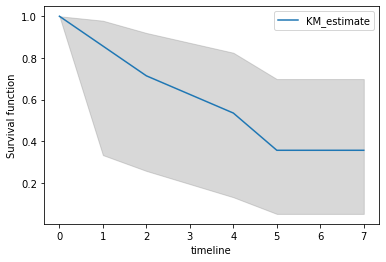

In [60]:
ts = ci.index
low, high = np.transpose(ci.values)

plt.fill_between(ts, low, high, color='gray', alpha=0.3)
kmf.survival_function_.plot(ax=plt.gca())
plt.ylabel('Survival function');